<a href="https://colab.research.google.com/github/shay-dan/DS_workshop_OpenUIL/blob/main/Preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3.Preprocess

We start by downloading the github repo:

In [ ]:
!git clone https://github.com/Liang-yc/ECUSTFD-resized-.git

Cloning into 'ECUSTFD-resized-'...
remote: Enumerating objects: 9232, done.
remote: Total 9232 (delta 0), reused 0 (delta 0), pack-reused 9232
Receiving objects: 100% (9232/9232), 124.79 MiB | 25.08 MiB/s, done.
Resolving deltas: 100% (6129/6129), done.
Updating files: 100% (5962/5962), done.


In [ ]:
import pandas as pd
import numpy as np
import re
import os
import glob
import xml.etree.ElementTree as ET
import shutil
import logging
logging.getLogger().setLevel(logging.CRITICAL)
import random
import json
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import seaborn as sns
sns.set(style = "dark",
        color_codes = True,
        font_scale = 1.5)

Let's get a feel for out dataset

In [ ]:
!ls /content/ECUSTFD-resized-

Annotations  density.xls  ImageSets  JPEGImages  README.md


In [ ]:
ins_array = ['train', 'val', 'trainval','test']
files_map = {}
path = '/content/ECUSTFD-resized-/ImageSets/Main/'
for i in ins_array:
  with open(path + i + '.txt', 'r') as f:
    files_map[i] = f.readlines()
  print("number of images in" , i , "split is: " ,len(files_map[i]))

number of images in train split is:  622
number of images in val split is:  623
number of images in trainval split is:  1245
number of images in test split is:  1733


In [ ]:
w_v_df = pd.read_excel(
    "/content/ECUSTFD-resized-/density.xls",
    sheet_name=None,
)
w_v_df = pd.concat(w_v_df.values(), axis=0)
w_v_df = w_v_df.reset_index(drop=True)
w_v_df

id     type  volume(mm^3)  weight(g)
0      apple001    apple           310      244.5
1      apple002    apple           290      232.5
2      apple003    apple           280      219.0
3      apple004    apple           300      234.0
4      apple005    apple           280      212.5
..          ...      ...           ...        ...
169  sachima005  sachima           150       32.7
170   tomato001   tomato           210      214.5
171   tomato002   tomato           190      154.2
172   tomato003   tomato           180      186.4
173   tomato004   tomato           160      173.4

[174 rows x 4 columns]

Looks like the designated train/val/test split isn't good, as the test set is more than 50% of the data. we'll have to use a different one. we also have ground truth for our volume and weight, for all the 174 unique food items in the images.

First we check if any there are any bad filenames and fix them if found:

In [ ]:
bad_ext= []
bad_fnames = []
print("checking annotations extensions")
for dirpath, _, filenames in os.walk('/content/ECUSTFD-resized-/Annotations'):
  for filename in filenames:
    if filename.split(".")[1] != 'xml':
      bad_ext.append(filename)
if bad_ext != []:
  print("wrong annotations extensions (should all be 'xml'):")
  for bad in bad_ext:
    print(bad)
else:
  print("all annotations extensions are OK\n")
# let's check if any S,T are lowercase
print("checking annotations filenames")
for file in os.listdir('/content/ECUSTFD-resized-/Annotations'):
  tmp = file.split(".")[0]
  split = tmp.split("(")[0]
  if split[-1] == 's':
    bad_fnames.append(file)
  if split[-1] == 't':
    bad_fnames.append(file)
if bad_fnames != []:
  print("bad annotations filenames (should all be have 'S' or 'T'):")
  for bad in bad_fnames:
    print(bad)
else:
  print("all annotations filenames are OK")

bad_ext= []
bad_fnames = []
print("\nchecking images extensions")
for dirpath, _, filenames in os.walk('/content/ECUSTFD-resized-/JPEGImages'):
  for filename in filenames:
    if filename.split(".")[1] != 'JPG':
      bad_ext.append(filename)
if bad_ext != []:
  print("wrong images extensions (should all be 'JPG'):")
  for bad in bad_ext:
    print(bad)
else:
  print("all images extensions are OK\n")
# let's check if any S,T are lowercase
print("checking images filenames")
for file in os.listdir('/content/ECUSTFD-resized-/JPEGImages'):
  tmp = file.split(".")[0]
  split = tmp.split("(")[0]
  if split[-1] == 's':
    bad_fnames.append(file)
  if split[-1] == 't':
    bad_fnames.append(file)
if bad_fnames != []:
  print("bad images filenames (should all be have 'S' or 'T'):")
  for bad in bad_fnames:
    print(bad)
else:
  print("all images filenames are OK")


checking annotations extensions
all annotations extensions are OK

checking annotations filenames
bad annotations filenames (should all be have 'S' or 'T'):
egg002s(8).xml
egg002s(9).xml
egg002s(2).xml
egg002s(4).xml
egg002s(3).xml
egg002s(7).xml
egg002s(1).xml
egg002s(6).xml
egg002s(5).xml

checking images extensions
all images extensions are OK

checking images filenames
bad images filenames (should all be have 'S' or 'T'):
egg002s(9).JPG
egg002s(1).JPG
egg002s(8).JPG
egg002s(3).JPG
egg002s(6).JPG
egg002s(7).JPG
egg002s(2).JPG
egg002s(4).JPG
egg002s(5).JPG


In [ ]:
# let's fix the lower case
for file in os.listdir('/content/ECUSTFD-resized-/Annotations/'):
  tmp = file.split(".")[0]
  split = tmp.split("(")[0]
  if split[-1] == 's':
    t = file.replace("s(","S(")
    os.rename('/content/ECUSTFD-resized-/Annotations/' + file,'/content/ECUSTFD-resized-/Annotations/' + t)

# let's fix the lower case
for file in os.listdir('/content/ECUSTFD-resized-/JPEGImages/'):
  tmp = file.split(".")[0]
  split = tmp.split("(")[0]
  if split[-1] == 's':
    t = file.replace("s(","S(")
    os.rename('/content/ECUSTFD-resized-/JPEGImages/' + file,'/content/ECUSTFD-resized-/JPEGImages/' + t)

Let's load all the annotations into a CSV file to help us explore it

In [ ]:
# Function that will extract column data for our CSV file
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbox = [0,0,0,0]
            bbox[0] = int(member[4][0].text)
            bbox[1] = int(member[4][1].text)
            bbox[2] = int(member[4][2].text)
            bbox[3] = int(member[4][3].text)
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     int(root.find('size')[2].text),
                     member[0].text,
                     (root.find('filename').text).split("0")[0],
                     bbox,
                     "/content/ECUSTFD-resized-/JPEGImages/" + root.find('filename').text
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'channels','instance', 'class', 'bbox','Image']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

total_df = xml_to_csv('/content/ECUSTFD-resized-/Annotations')
total_df.to_csv(('total.csv'), index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


First we are going to change our dataset format from PASCAL VOC to COCO

In [ ]:
!pip install pylabel > /dev/null
from pylabel import importer

In [ ]:
dataset = importer.ImportVOC(path="/content/ECUSTFD-resized-/Annotations", path_to_images="/content/ECUSTFD-resized-/JPEGImages", name="All")
dataset.export.ExportToCoco()

Exporting to COCO file...: 100%|██████████| 6062/6062 [00:03<00:00, 1879.63it/s]


['/content/ECUSTFD-resized-/Annotations/All.json']

Now let's see some images and bounding boxes:

In [ ]:
def display_images(image_paths):
    fig, axs = plt.subplots(5, 4, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        tmp = (img_path.split("/JPEGImages/")[1]).split("0")[0]
        ax.set_title(tmp, fontsize=10)
        ax.imshow(image)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.15)
    plt.show()

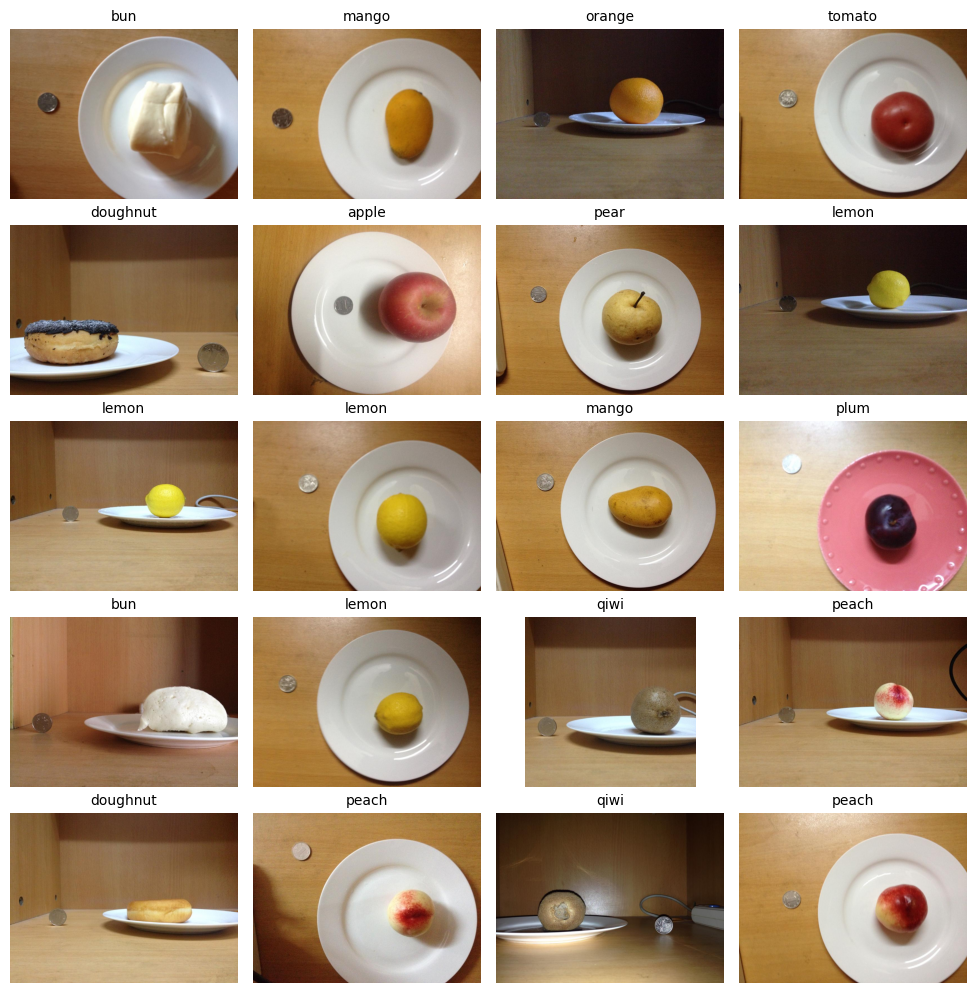

In [ ]:
with open('/content/ECUSTFD-resized-/Annotations/All.json', 'r') as f:
    annotations = json.load(f)

image_dir = "/content/ECUSTFD-resized-/JPEGImages/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 20)
display_images(random_image_files)

We can see that our images are in RGB format. Each image should have a coin for calibration, all should have 1 or 2 food pieces in them

In [ ]:
def display_images_with_coco_annotations(image_paths, annotations, colors=None):
    fig, axs = plt.subplots(4, 5, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        tmp = (img_path.split("/JPEGImages/")[1]).split("0")[0]
        ax.set_title(tmp, fontsize=10)
        ax.imshow(image)
        ax.axis('off')

        if colors is None:
            colors = plt.cm.get_cmap('tab10')

        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        for ann in img_annotations:
            category_id = ann['category_id']
            color = colors(category_id % 10)

            bbox = ann['bbox']
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

<ipython-input-13-94e3043b07bf>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


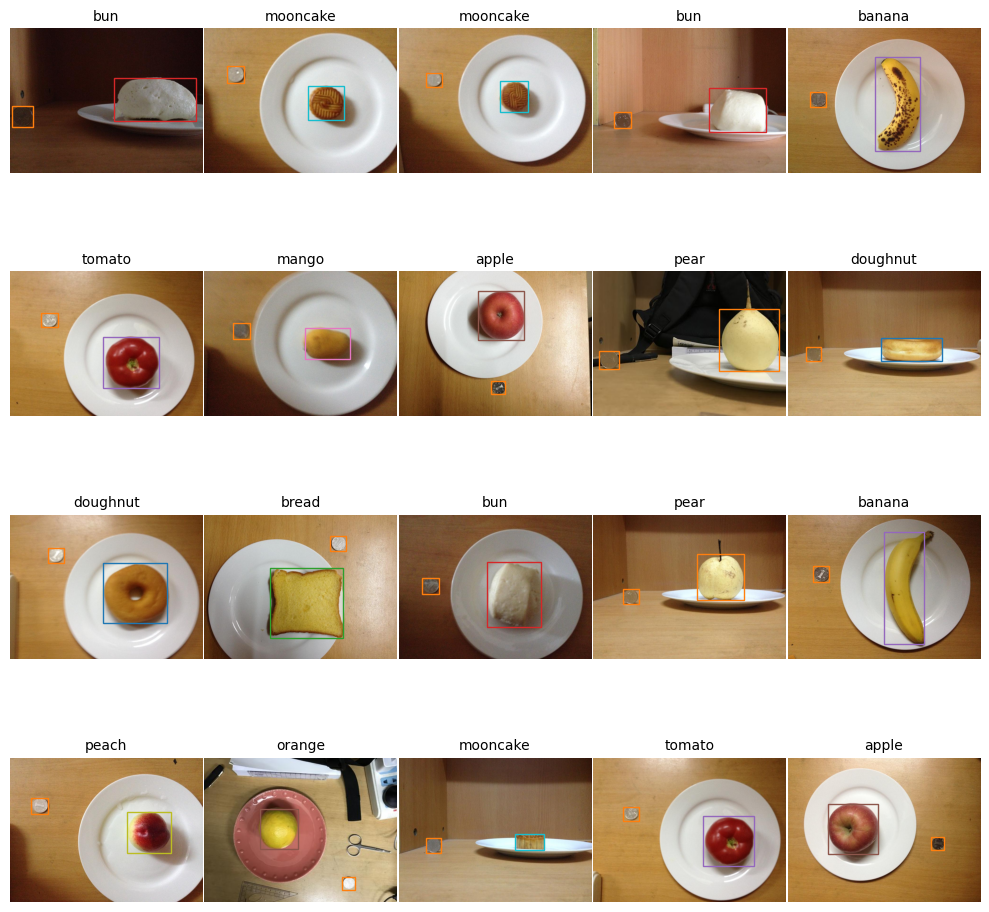

In [ ]:
with open('/content/ECUSTFD-resized-/Annotations/All.json', 'r') as f:
    annotations = json.load(f)

image_dir = "/content/ECUSTFD-resized-/JPEGImages/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 20)
display_images_with_coco_annotations(random_image_files, annotations)

Let's explore some basic attributes

In [ ]:
total_df

filename  width  height  channels  instance     class  \
0      doughnut003T(3).JPG    816     612         3  doughnut  doughnut   
1      doughnut003T(3).JPG    816     612         3      coin  doughnut   
2         bread003S(3).JPG    816     612         3     bread     bread   
3         bread003S(3).JPG    816     612         3      coin     bread   
4          plum004T(3).JPG    816     612         3      plum      plum   
...                    ...    ...     ...       ...       ...       ...   
6057   mooncake006T(3).JPG    816     612         3      coin  mooncake   
6058        bun004S(4).JPG    816     612         3       bun       bun   
6059        bun004S(4).JPG    816     612         3      coin       bun   
6060  doughnut006S(12).JPG    816     612         3  doughnut  doughnut   
6061  doughnut006S(12).JPG    816     612         3      coin  doughnut   

                      bbox                                              Image  
0     [227, 278, 496, 552]  /content/ECUSTFD-resized-/JPEGImages/doughnut0...  
1      [562, 97, 626, 167]  /content/ECUSTFD-resized-/JPEGImages/doughnut0...  
2      [46, 369, 513, 447]  /content/ECUSTFD-resized-/JPEGImages/bread003S...  
3     [695, 366, 777, 449]  /content/ECUSTFD-resized-/JPEGImages/bread003S...  
4     [445, 302, 616, 453]  /content/ECUSTFD-resized-/JPEGImages/plum004T(...  
...                    ...                                                ...  
6057   [82, 248, 158, 323]  /content/ECUSTFD-resized-/JPEGImages/mooncake0...  
6058  [103, 260, 378, 393]  /content/ECUSTFD-resized-/JPEGImages/bun004S(4...  
6059  [717, 338, 779, 399]  /content/ECUSTFD-resized-/JPEGImages/bun004S(4...  
6060  [395, 286, 661, 375]  /content/ECUSTFD-resized-/JPEGImages/doughnut0...  
6061  [107, 332, 173, 395]  /content/ECUSTFD-resized-/JPEGImages/doughnut0...  

[6062 rows x 8 columns]

Let's check if all images have coins in them for calibration and have bboxes:

In [ ]:
total_df["instance"].value_counts()

coin                 2976
apple                 322
orange                281
mango                 250
banana                212
doughnut              210
tomato                201
lemon                 185
pear                  182
plum                  176
sachima               150
qiwi                  137
mooncake              134
peach                 126
fired_dough_twist     124
egg                   104
bun                    90
litchi                 78
bread                  66
grape                  58
Name: instance, dtype: int64

Looks like we have 2 images without coins. Let's find them

(in the dataset github it says that 2 images are missing coins!)

In [ ]:
check = []
regular = []
for i, file in enumerate(total_df["filename"]):
    #if file has no coin instance
    if total_df["instance"][i] != 'coin':
      #filenames to be checked
      check.append(file)
    else:
      #with a coin
      regular.append(file)

no_coin = []
for i, file in enumerate(total_df['filename']):
    # filename is ok
    if total_df['filename'][i] in regular:
      continue
    else:
      no_coin.append(total_df['filename'][i])

no_coin = list(set(no_coin))
no_coin

['mix005S(4).JPG', 'mix002T(2).JPG']

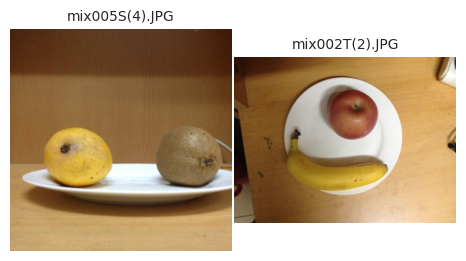

In [ ]:
no_coin_img = [image_dir + no_coin[0],image_dir + no_coin[1]]
fig, axs = plt.subplots(1, 2, figsize=(5, 5))

for ax, img_path in zip(axs.ravel(), no_coin_img):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tmp = img_path.split("/JPEGImages/")[1]
    ax.set_title(tmp, fontsize=10)
    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.15)
plt.show()

Now for the bounding boxes:

In [ ]:
total_df["bbox"].empty

False

The dataframe is more than double the size of our dataset, since we get a row in the dataframe for all different instances in every class. we'll drop duplicates to analyze it.

In [ ]:
total_df_no_dups = pd.read_csv("total.csv")
total_df_no_dups.drop_duplicates(subset="filename",
                     keep="first", inplace=True,ignore_index = True)
total_df_no_dups

filename  width  height  channels  \
0                 lemon002S(5).JPG    816     612         3   
1                 plum001S(19).JPG    816     612         3   
2                 apple015T(3).JPG    816     612         3   
3     fired_dough_twist002S(6).JPG    816     612         3   
4                litchi005S(8).JPG    816     612         3   
...                            ...    ...     ...       ...   
2973            tomato003T(16).JPG    816     612         3   
2974               plum003T(1).JPG    816     612         3   
2975             tomato001S(7).JPG    816     612         3   
2976          doughnut006T(14).JPG    816     612         3   
2977               pear005S(5).JPG    504     378         3   

               instance              class                  bbox  \
0                 lemon              lemon  [498, 295, 657, 420]   
1                  plum               plum  [471, 184, 666, 353]   
2                 apple              apple  [436, 207, 723, 469]   
3     fired_dough_twist  fired_dough_twist  [436, 250, 695, 376]   
4                litchi             litchi  [499, 329, 613, 436]   
...                 ...                ...                   ...   
2973             tomato             tomato  [408, 242, 619, 456]   
2974               plum               plum  [435, 290, 613, 455]   
2975             tomato             tomato  [409, 233, 602, 372]   
2976           doughnut           doughnut  [403, 228, 663, 515]   
2977               pear               pear   [317, 99, 465, 263]   

                                                  Image  
0     /content/ECUSTFD-resized-/JPEGImages/lemon002S...  
1     /content/ECUSTFD-resized-/JPEGImages/plum001S(...  
2     /content/ECUSTFD-resized-/JPEGImages/apple015T...  
3     /content/ECUSTFD-resized-/JPEGImages/fired_dou...  
4     /content/ECUSTFD-resized-/JPEGImages/litchi005...  
...                                                 ...  
2973  /content/ECUSTFD-resized-/JPEGImages/tomato003...  
2974  /content/ECUSTFD-resized-/JPEGImages/plum003T(...  
2975  /content/ECUSTFD-resized-/JPEGImages/tomato001...  
2976  /content/ECUSTFD-resized-/JPEGImages/doughnut0...  
2977  /content/ECUSTFD-resized-/JPEGImages/pear005S(...  

[2978 rows x 8 columns]

Let's check image dimenstions distribution:

<ipython-input-22-aa90d8ddcff0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=[label for label in labels_height.index], y=labels_height.values, palette=np.array(pal[::-1])[rank])
<ipython-input-22-aa90d8ddcff0>:8: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(ax=axes[0], x=[label for label in labels_height.index], y=labels_height.values, palette=np.array(pal[::-1])[rank])
<ipython-input-22-aa90d8ddcff0>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=[label for label in labels_width.index], y=labels_width.values, palette=np.array(pal[::-1])[rank])
<ipyt

Text(0.5, 1.0, 'Channels')

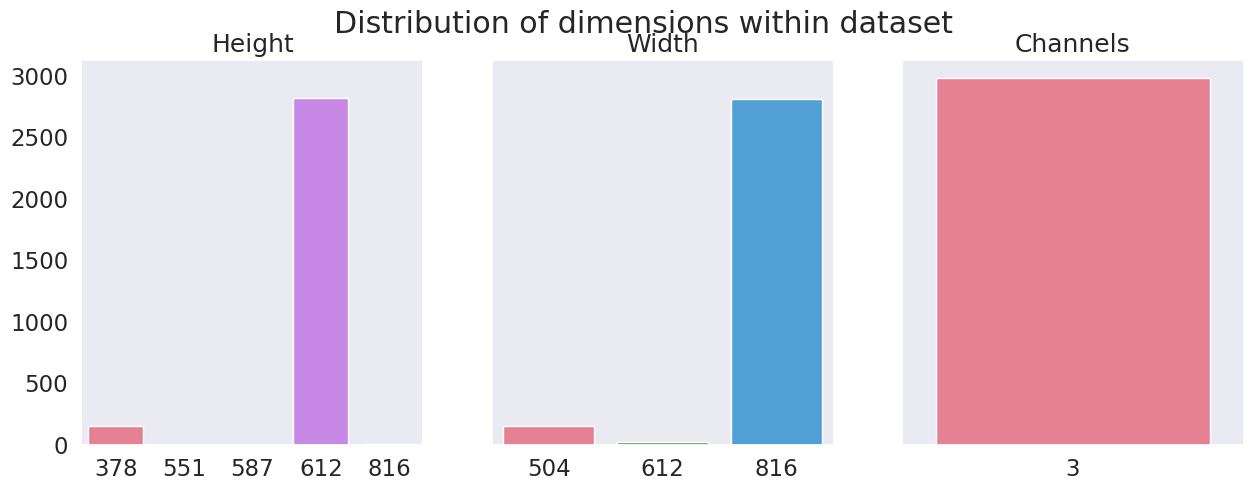

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Distribution of dimensions within dataset')

labels_height = total_df_no_dups["height"].value_counts()
pal = sns.color_palette("husl", len(labels_height))
rank = labels_height.argsort().argsort()

sns.barplot(ax=axes[0], x=[label for label in labels_height.index], y=labels_height.values, palette=np.array(pal[::-1])[rank])
axes[0].set_title("Height")

labels_width = total_df_no_dups["width"].value_counts()
pal = sns.color_palette("husl", len(labels_width))
rank = labels_width.argsort().argsort()

sns.barplot(ax=axes[1], x=[label for label in labels_width.index], y=labels_width.values, palette=np.array(pal[::-1])[rank])
axes[1].set_title("Width")

labels_channels = total_df_no_dups["channels"].value_counts()
pal = sns.color_palette("husl", len(labels_channels))
rank = labels_channels.argsort().argsort()

sns.barplot(ax=axes[2], x=[label for label in labels_channels.index], y=labels_channels.values, palette=np.array(pal[::-1])[rank])
axes[2].set_title("Channels")

Looks like that most of our images are 612h, 816w, and all in RGB format

Now let's explore the classes. classes are based on filenames, that means we set a class "mix" and no class "coin".

In [ ]:
total_df_no_dups["class"].value_counts()

apple                296
orange               254
mango                220
doughnut             210
banana               178
plum                 176
tomato               172
pear                 166
sachima              150
lemon                148
mooncake             134
peach                126
fired_dough_twist    124
qiwi                 120
mix                  108
egg                  104
bun                   90
litchi                78
bread                 66
grape                 58
Name: class, dtype: int64

We can see that we have a huge class imbalance. Let's plot it.

<ipython-input-24-554b6f0348ba>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[label for label in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
<ipython-input-24-554b6f0348ba>:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(x=[label for label in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
<ipython-input-24-554b6f0348ba>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


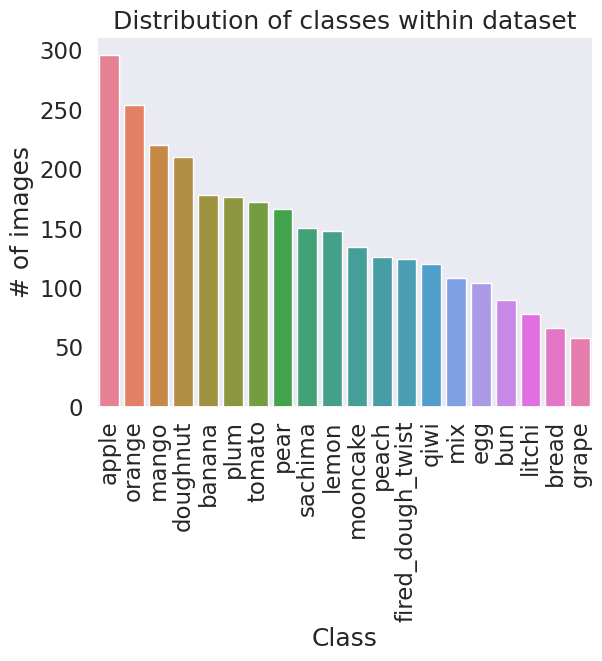

In [ ]:
labels = total_df_no_dups["class"].value_counts()

pal = sns.color_palette("husl", len(labels))
rank = labels.argsort().argsort()

ax = sns.barplot(x=[label for label in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
plt.title("Distribution of classes within dataset")
plt.ylabel("# of images")
plt.xlabel("Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Now let's check for overlaps in our bounding boxes via IoU calculation:

In [ ]:
def bb_intersection_over_union(boxA, boxB):
  # determine the (x, y)-coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  return interArea

In [ ]:
def get_bad_bboxes(total_df):
  bad_list = []
  for name in total_df["filename"].unique():
    idx = (np.array(np.where(total_df["filename"] == name)[0]))
    if len(idx) == 2: # for images with coin and another class
      a = (bb_intersection_over_union(total_df['bbox'][idx[0]], total_df['bbox'][idx[1]]))
      if a > 0: # if > 0 it means there's an overlap
        bad_list.append(name)
    else: # for images with coin and 2 other classes, we check for all 3 options
      b = (bb_intersection_over_union(total_df['bbox'][idx[0]], total_df['bbox'][idx[1]]))
      c = (bb_intersection_over_union(total_df['bbox'][idx[0]], total_df['bbox'][idx[2]]))
      d = (bb_intersection_over_union(total_df['bbox'][idx[1]], total_df['bbox'][idx[2]]))
      if b > 0:
        bad_list.append(name)
      if c > 0:
        bad_list.append(name)
      if d > 0:
        bad_list.append(name)
  return bad_list

In [ ]:
bad_list = get_bad_bboxes(total_df)
print("number of bad annotations is:", len(bad_list))

number of bad annotations is: 51


Let's understand where the problem is by looking:

<ipython-input-13-94e3043b07bf>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


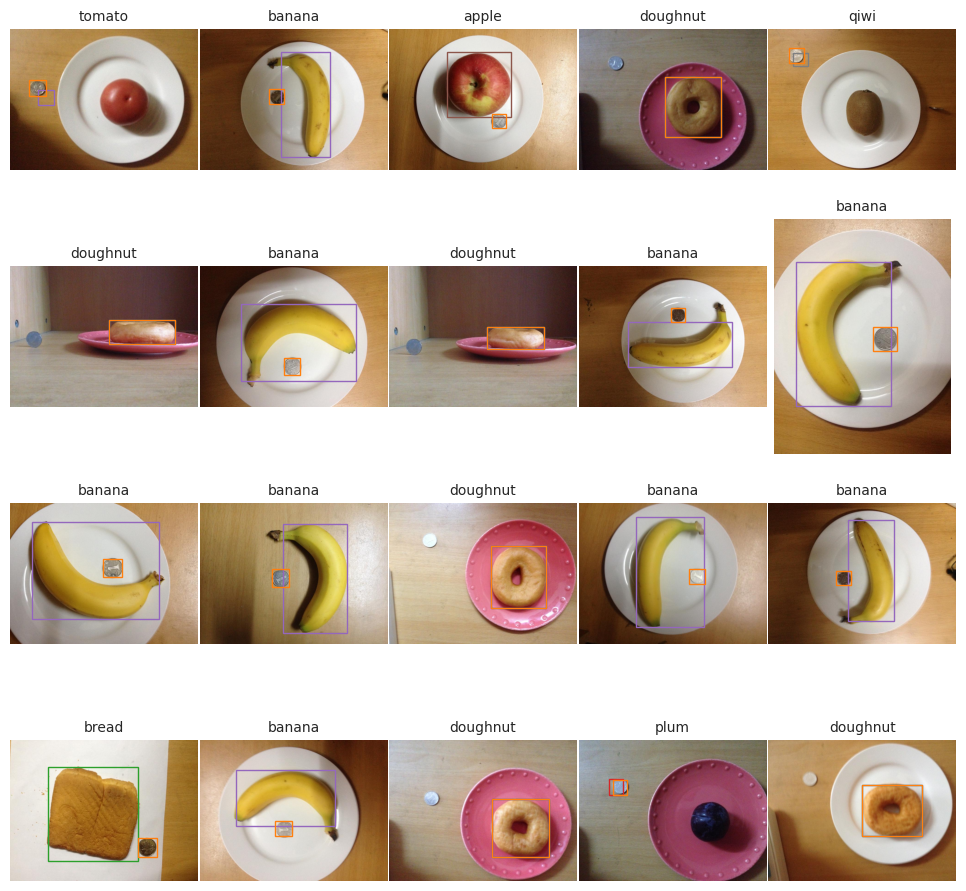

In [ ]:
with open('/content/ECUSTFD-resized-/Annotations/All.json', 'r') as f:
    annotations = json.load(f)

image_dir = "/content/ECUSTFD-resized-/JPEGImages/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
bad_list_path = []
for name in bad_list:
 bad_list_path.append(image_dir + name)
random_image_files = random.sample(bad_list_path, 20)
display_images_with_coco_annotations(random_image_files, annotations)

We can see some random bad annotations. We have a total of 53 images with bad annotations - 2 without coins, and 51 with overlaping boxes. some are overlapping, some are misplaced. it is important to know that we might still have bad annotations, like misplaced bboxes, but we can't find them except by looking at all the images/bboxes.

Let's reload the dataset without the bad annotations and the 2 imags without coins (maybe we should use them in the test set?)

In [ ]:
new_bad_list = bad_list.copy()
new_bad_list.append(no_coin[0])
new_bad_list.append(no_coin[1])
print(len(new_bad_list))

53


In [ ]:
total_df_cleaned = total_df.copy()
for i,name in enumerate(total_df_cleaned['filename']):
  if name in new_bad_list:
    total_df_cleaned = total_df_cleaned.drop(i)
total_df_cleaned = total_df_cleaned.reset_index(drop=True)
total_df_cleaned

filename  width  height  channels  instance     class  \
0         lemon002S(5).JPG    816     612         3     lemon     lemon   
1         lemon002S(5).JPG    816     612         3      coin     lemon   
2         plum001S(19).JPG    816     612         3      plum      plum   
3         plum001S(19).JPG    816     612         3      coin      plum   
4         apple015T(3).JPG    816     612         3     apple     apple   
...                    ...    ...     ...       ...       ...       ...   
5949     tomato001S(7).JPG    816     612         3      coin    tomato   
5950  doughnut006T(14).JPG    816     612         3  doughnut  doughnut   
5951  doughnut006T(14).JPG    816     612         3      coin  doughnut   
5952       pear005S(5).JPG    504     378         3      pear      pear   
5953       pear005S(5).JPG    504     378         3      coin      pear   

                      bbox                                              Image  
0     [498, 295, 657, 420]  /content/ECUSTFD-resized-/JPEGImages/lemon002S...  
1     [194, 371, 250, 435]  /content/ECUSTFD-resized-/JPEGImages/lemon002S...  
2     [471, 184, 666, 353]  /content/ECUSTFD-resized-/JPEGImages/plum001S(...  
3     [124, 299, 202, 369]  /content/ECUSTFD-resized-/JPEGImages/plum001S(...  
4     [436, 207, 723, 469]  /content/ECUSTFD-resized-/JPEGImages/apple015T...  
...                    ...                                                ...  
5949   [71, 331, 140, 394]  /content/ECUSTFD-resized-/JPEGImages/tomato001...  
5950  [403, 228, 663, 515]  /content/ECUSTFD-resized-/JPEGImages/doughnut0...  
5951  [152, 144, 221, 209]  /content/ECUSTFD-resized-/JPEGImages/doughnut0...  
5952   [317, 99, 465, 263]  /content/ECUSTFD-resized-/JPEGImages/pear005S(...  
5953     [5, 211, 56, 259]  /content/ECUSTFD-resized-/JPEGImages/pear005S(...  

[5954 rows x 8 columns]

In [ ]:
print("# of unique filenames:" ,len(total_df_cleaned['filename'].unique()))
print("per instance count:")
total_df_cleaned['instance'].value_counts()

# of unique filenames: 2925
per instance count:


coin                 2925
apple                 318
orange                279
mango                 246
banana                195
doughnut              194
tomato                194
lemon                 185
pear                  182
plum                  175
sachima               150
mooncake              134
qiwi                  133
peach                 126
fired_dough_twist     124
egg                   104
bun                    90
litchi                 78
bread                  64
grape                  58
Name: instance, dtype: int64

Now let's reload the dataset json without the bad annotaions

In [ ]:
def manage_dataset_clean(path = '/content/ECUSTFD-resized-/Annotations/',dataframe = total_df_cleaned):
  root = '/content/Ecustfd-COCO-no-seg-masks-cleaned/'
  anns_path = "/content/ECUSTFD-resized-/Annotations/"
  path_to_images = "/content/ECUSTFD-resized-/JPEGImages/"

  if not os.path.exists(root):
    os.mkdir(root)

  if not os.path.exists(root + 'JPEGImages/'):
    os.mkdir(root + 'JPEGImages/')

  for file in os.listdir(path):
    tmp = file.split(".xml")[0]
    for name in dataframe["filename"].unique():
      if name.split(".JPG")[0] == tmp:
        shutil.copyfile(anns_path + file, root + 'JPEGImages/' +  file)

  path_to_annotations = (root + 'JPEGImages/')
  return path_to_annotations, path_to_images

In [ ]:
path_to_annotations, path_to_images = manage_dataset_clean(path = '/content/ECUSTFD-resized-/Annotations/',dataframe = total_df_cleaned)

In [ ]:
dataset = importer.ImportVOC(path=path_to_annotations, path_to_images=path_to_images, name="AllClean")
dataset.export.ExportToCoco()

Exporting to COCO file...: 100%|██████████| 5936/5936 [00:03<00:00, 1840.15it/s]


['/content/Ecustfd-COCO-no-seg-masks-cleaned/JPEGImages/AllClean.json']

looks like we're missing a few files, there should be 2925

In [ ]:
files_df = []
for file in total_df_cleaned["filename"].unique():
  tmp = file.split(".JPG")[0]
  files_df.append(tmp)
files_df = sorted(files_df)

files_dir = []
for file in os.listdir("/content/Ecustfd-COCO-no-seg-masks-cleaned/JPEGImages"):
  if file == "AllClean.json":
    continue
  else:
    tmp = file.split(".xml")[0]
    files_dir.append(tmp)
files_dir = sorted(files_dir)

In [ ]:
print(len(files_df),len(files_dir))

2925 2916


looks like not all files were copied

In [ ]:
diff = set(files_df) - set(files_dir)
diff

{'egg002s(1)',
 'egg002s(2)',
 'egg002s(3)',
 'egg002s(4)',
 'egg002s(5)',
 'egg002s(6)',
 'egg002s(7)',
 'egg002s(8)',
 'egg002s(9)'}

The same files we found at the beginning, now the problem was because how they were written in the xml file to begin with. let's rename those files with 'S'

In [ ]:
for file in diff:
  idx = (list(np.where(total_df_cleaned["filename"] == file + ".JPG")))
  tmp = file.replace("s(","S(")
  total_df_cleaned["filename"][idx[0][0]] = tmp
  total_df_cleaned["filename"][idx[0][1]] = tmp


<ipython-input-36-91ea5b60211e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_cleaned["filename"][idx[0][0]] = tmp
<ipython-input-36-91ea5b60211e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_cleaned["filename"][idx[0][1]] = tmp


now let's reload the data

In [ ]:
shutil.rmtree("/content/Ecustfd-COCO-no-seg-masks-cleaned", ignore_errors=True)

In [ ]:
path_to_annotations, path_to_images = manage_dataset_clean(path = '/content/ECUSTFD-resized-/Annotations/',dataframe = total_df_cleaned)
dataset = importer.ImportVOC(path=path_to_annotations, path_to_images=path_to_images, name="AllClean")
dataset.export.ExportToCoco()

Exporting to COCO file...: 100%|██████████| 5954/5954 [00:04<00:00, 1447.93it/s]


['/content/Ecustfd-COCO-no-seg-masks-cleaned/JPEGImages/AllClean.json']

In [ ]:
for i, bad_filename in enumerate(total_df_cleaned["Image"]):
  if bad_filename.split("(")[0][-1] == 's':
    total_df_cleaned["Image"][i] = total_df_cleaned["Image"][i].replace("s(","S(")

<ipython-input-39-8855bf8e2d30>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_cleaned["Image"][i] = total_df_cleaned["Image"][i].replace("s(","S(")


In [ ]:
for i, bad_filename in enumerate(total_df_cleaned["Image"]):
  if bad_filename.split("(")[0][-1] == 's':
    print(bad_filename)

In [ ]:
total_df_cleaned_no_dups = total_df_cleaned.copy()
total_df_cleaned_no_dups.drop_duplicates(subset="filename",
                     keep="first", inplace=True,ignore_index = True)
total_df_cleaned_no_dups

filename  width  height  channels  \
0                 lemon002S(5).JPG    816     612         3   
1                 plum001S(19).JPG    816     612         3   
2                 apple015T(3).JPG    816     612         3   
3     fired_dough_twist002S(6).JPG    816     612         3   
4                litchi005S(8).JPG    816     612         3   
...                            ...    ...     ...       ...   
2920            tomato003T(16).JPG    816     612         3   
2921               plum003T(1).JPG    816     612         3   
2922             tomato001S(7).JPG    816     612         3   
2923          doughnut006T(14).JPG    816     612         3   
2924               pear005S(5).JPG    504     378         3   

               instance              class                  bbox  \
0                 lemon              lemon  [498, 295, 657, 420]   
1                  plum               plum  [471, 184, 666, 353]   
2                 apple              apple  [436, 207, 723, 469]   
3     fired_dough_twist  fired_dough_twist  [436, 250, 695, 376]   
4                litchi             litchi  [499, 329, 613, 436]   
...                 ...                ...                   ...   
2920             tomato             tomato  [408, 242, 619, 456]   
2921               plum               plum  [435, 290, 613, 455]   
2922             tomato             tomato  [409, 233, 602, 372]   
2923           doughnut           doughnut  [403, 228, 663, 515]   
2924               pear               pear   [317, 99, 465, 263]   

                                                  Image  
0     /content/ECUSTFD-resized-/JPEGImages/lemon002S...  
1     /content/ECUSTFD-resized-/JPEGImages/plum001S(...  
2     /content/ECUSTFD-resized-/JPEGImages/apple015T...  
3     /content/ECUSTFD-resized-/JPEGImages/fired_dou...  
4     /content/ECUSTFD-resized-/JPEGImages/litchi005...  
...                                                 ...  
2920  /content/ECUSTFD-resized-/JPEGImages/tomato003...  
2921  /content/ECUSTFD-resized-/JPEGImages/plum003T(...  
2922  /content/ECUSTFD-resized-/JPEGImages/tomato001...  
2923  /content/ECUSTFD-resized-/JPEGImages/doughnut0...  
2924  /content/ECUSTFD-resized-/JPEGImages/pear005S(...  

[2925 rows x 8 columns]

## Summary

We fixed the following issues we found in the dataset:
- Renamed wrong filenames (images and annotations) : change 's' to 'S'
- Removed images with overlapping bounding box
- Removed images without coins

We explored the dataset and notice the following:
- Imbalances with class distribution
- Most images has the same height and width
- All images in RGB format
